In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 500)

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.metrics import silhouette_samples, silhouette_score
from pandas.plotting import parallel_coordinates

from IPython.display import display
import itertools
from collections import Counter
import json

# 각 게임의 점수 계산
- 긍정 리뷰 수 - 부정 리뷰 수
- Aspect별 점수 계산

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/absa_data.csv")
aspects = ["gameplay", "market", "social", "narrative", "graphics", "technical", "value", "audio"]

In [ ]:
# 결과를 저장할 빈 데이터프레임 생성
results_df = pd.DataFrame(columns=['appid'] + aspects + ['total'])

# groupby로 각 appid별로 데이터 추출
grouped = df.groupby('appid')
for name, group in tqdm(grouped):
    # 각 appid별로 결과를 저장할 딕셔너리 생성
    results = {'appid': name}

    # 각 aspect별로 score 및 개수 계산
    for aspect in aspects:
        # score 계산
        score = group[group[f"{aspect}_label"] == 2].shape[0] - group[group[f"{aspect}_label"] == 0].shape[0]
        # 개수 계산
        count = group[group[f"{aspect}_label"] == 0].shape[0] + group[group[f"{aspect}_label"] == 1].shape[0] + group[group[f"{aspect}_label"] == 2].shape[0]
        # 딕셔너리에 저장
        results[aspect] = score
        results[f"{aspect}_count"] = count

    # 총 개수 계산
    total_count = group.shape[0]
    results['total'] = total_count

    # 결과를 데이터프레임에 추가
    results_df = results_df.append(results, ignore_index=True)

In [ ]:
results_df.head()

appid gameplay market social narrative graphics technical value audio total  \
0    70     2134    182    244       479     -336        96   231   215  6766   
1   440     1316     62    719       119      252       113   299    62  5173   
2   570      121     21     10         9      122       -94     0    53  2989   
3  3010       26      5      7        10       10        16    22     1   103   
4  3130       -1      2      3         0        2        -4     8   -11   120   

   gameplay_count  market_count  social_count  narrative_count  \
0          4620.0         454.0         787.0           1109.0   
1          3053.0         304.0        1773.0            368.0   
2          1851.0         144.0        1309.0            106.0   
3            62.0           5.0           7.0             16.0   
4            93.0           5.0          11.0             14.0   

   graphics_count  technical_count  value_count  audio_count  
0          1889.0           1211.0        651.0        861.0  
1           499.0           1916.0        616.0        355.0  
2           211.0            587.0        162.0        157.0  
3            42.0             41.0         24.0         11.0  
4            14.0             18.0         20.0         25.0

# 클러스터링 : K-Means

In [ ]:
df_pivot = results_df.astype(float)
df_pivot

appid  gameplay  market  social  narrative  graphics  technical  \
0           70.0    2134.0   182.0   244.0      479.0    -336.0       96.0   
1          440.0    1316.0    62.0   719.0      119.0     252.0      113.0   
2          570.0     121.0    21.0    10.0        9.0     122.0      -94.0   
3         3010.0      26.0     5.0     7.0       10.0      10.0       16.0   
4         3130.0      -1.0     2.0     3.0        0.0       2.0       -4.0   
...          ...       ...     ...     ...        ...       ...        ...   
46918  2362350.0       1.0     0.0     0.0        0.0       0.0        0.0   
46919  2363460.0       1.0     0.0     0.0        0.0       0.0        0.0   
46920  2365430.0      18.0     0.0     1.0        0.0       1.0        7.0   
46921  2366320.0       1.0     1.0     0.0        0.0       1.0        0.0   
46922  2366321.0       1.0     1.0     1.0        0.0       0.0        0.0   

       value  audio   total  gameplay_count  market_count  social_count  \
0      231.0  215.0  6766.0          4620.0         454.0         787.0   
1      299.0   62.0  5173.0          3053.0         304.0        1773.0   
2        0.0   53.0  2989.0          1851.0         144.0        1309.0   
3       22.0    1.0   103.0            62.0           5.0           7.0   
4        8.0  -11.0   120.0            93.0           5.0          11.0   
...      ...    ...     ...             ...           ...           ...   
46918    0.0    0.0     1.0             1.0           0.0           0.0   
46919    0.0    0.0     1.0             1.0           0.0           0.0   
46920    8.0    0.0    29.0            23.0           0.0           1.0   
46921    1.0    1.0     1.0             1.0           1.0           0.0   
46922    1.0    0.0     1.0             1.0           1.0           1.0   

       narrative_count  graphics_count  technical_count  value_count  \
0               1109.0          1889.0           1211.0        651.0   
1                368.0           499.0           1916.0        616.0   
2                106.0           211.0            587.0        162.0   
3                 16.0            42.0             41.0         24.0   
4                 14.0            14.0             18.0         20.0   
...                ...             ...              ...          ...   
46918              0.0             0.0              0.0          0.0   
46919              0.0             0.0              0.0          0.0   
46920              0.0             1.0              7.0          8.0   
46921              0.0             1.0              0.0          1.0   
46922              0.0             0.0              0.0          1.0   

       audio_count  
0            861.0  
1            355.0  
2            157.0  
3             11.0  
4             25.0  
...            ...  
46918          0.0  
46919          0.0  
46920          0.0  
46921          1.0  
46922          0.0  

[46923 rows x 18 columns]

In [ ]:
# 이상치 제거 수행

def remove_outliers(data, threshold=3):
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    filtered_data = data[abs(z_scores) < threshold]
    return filtered_data

outlier_columns = ['gameplay', 'market', 'social', 'narrative', 'graphics', 'technical', 'value', 'audio', 'total', 'gameplay_count', 'market_count', 'social_count',
                    'narrative_count', 'graphics_count', 'technical_count', 'value_count', 'audio_count'] # appid 빼고

for column in outlier_columns:
    df_pivot[column] = remove_outliers(df_pivot[column])

df_pivot.head()

appid  gameplay  market  social  narrative  graphics  technical  value  \
0    70.0    2134.0   182.0   244.0      479.0    -336.0       96.0  231.0   
1   440.0    1316.0    62.0   719.0      119.0     252.0      113.0  299.0   
2   570.0     121.0    21.0    10.0        9.0     122.0      -94.0    0.0   
3  3010.0      26.0     5.0     7.0       10.0      10.0       16.0   22.0   
4  3130.0      -1.0     2.0     3.0        0.0       2.0       -4.0    8.0   

   audio   total  gameplay_count  market_count  social_count  narrative_count  \
0  215.0  6766.0          4620.0         454.0         787.0           1109.0   
1   62.0  5173.0          3053.0         304.0        1773.0            368.0   
2   53.0  2989.0          1851.0         144.0        1309.0            106.0   
3    1.0   103.0            62.0           5.0           7.0             16.0   
4  -11.0   120.0            93.0           5.0          11.0             14.0   

   graphics_count  technical_count  value_count  audio_count  
0             NaN           1211.0        651.0        861.0  
1           499.0           1916.0        616.0        355.0  
2           211.0            587.0        162.0        157.0  
3            42.0             41.0         24.0         11.0  
4            14.0             18.0         20.0         25.0

In [ ]:
df_pivot = df_pivot.dropna()
df_pivot = df_pivot.drop(['appid'], axis = 1)
df_pivot

gameplay  market  social  narrative  graphics  technical  value  audio  \
1        1316.0    62.0   719.0      119.0     252.0      113.0  299.0   62.0   
2         121.0    21.0    10.0        9.0     122.0      -94.0    0.0   53.0   
3          26.0     5.0     7.0       10.0      10.0       16.0   22.0    1.0   
4          -1.0     2.0     3.0        0.0       2.0       -4.0    8.0  -11.0   
5          46.0     9.0    -1.0        9.0      19.0        2.0   21.0   13.0   
...         ...     ...     ...        ...       ...        ...    ...    ...   
46127      19.0     2.0    31.0        1.0       6.0       10.0   17.0    3.0   
46346     -27.0    -6.0     0.0       -5.0     -22.0      -58.0  -13.0  -11.0   
46492     -17.0    -2.0    -3.0       -1.0      -1.0      -28.0  -37.0   -3.0   
46595      32.0     7.0    14.0        2.0       0.0        5.0   48.0    2.0   
46688      47.0     5.0    26.0        4.0       9.0       -2.0    8.0   12.0   

        total  gameplay_count  market_count  social_count  narrative_count  \
1      5173.0          3053.0         304.0        1773.0            368.0   
2      2989.0          1851.0         144.0        1309.0            106.0   
3       103.0            62.0           5.0           7.0             16.0   
4       120.0            93.0           5.0          11.0             14.0   
5       144.0            96.0          17.0           5.0             25.0   
...       ...             ...           ...           ...              ...   
46127   102.0            35.0           2.0          56.0              7.0   
46346   388.0           241.0          29.0          33.0             57.0   
46492   152.0            84.0          10.0           6.0             18.0   
46595   128.0            56.0           8.0          18.0              3.0   
46688   110.0            66.0           7.0          35.0             12.0   

       graphics_count  technical_count  value_count  audio_count  
1               499.0           1916.0        616.0        355.0  
2               211.0            587.0        162.0        157.0  
3                42.0             41.0         24.0         11.0  
4                14.0             18.0         20.0         25.0  
5                34.0             14.0         29.0         23.0  
...               ...              ...          ...          ...  
46127             7.0             36.0         21.0          6.0  
46346            66.0             82.0         46.0         71.0  
46492             1.0             58.0        114.0         10.0  
46595             0.0             15.0         71.0          2.0  
46688            19.0             16.0         14.0         16.0  

[4270 rows x 17 columns]

In [ ]:
# Mean Normalization을 수행한 후, 데이터를 표준화
scaler = StandardScaler()
scaler.fit(df_pivot)
df_pivot2 = scaler.transform(df_pivot)

# 정규화된 데이터를 DataFrame으로 변환
df_pivot = pd.DataFrame(df_pivot2, columns=df_pivot.columns)

# 변환된 DataFrame 출력
df_pivot.head()

gameplay    market    social  narrative  graphics  technical     value  \
0  4.475244  2.288549  6.673113   1.148476  2.606041   1.099899  2.822633   
1 -0.035124  0.584825 -0.191812  -0.259897  1.020793  -0.806460 -0.481629   
2 -0.393689 -0.080043 -0.220860  -0.247093 -0.344959   0.206581 -0.238506   
3 -0.495596 -0.204706 -0.259590  -0.375127 -0.442513   0.022392 -0.393220   
4 -0.318201  0.086174 -0.298320  -0.259897 -0.235211   0.077649 -0.249557   

      audio     total  gameplay_count  market_count  social_count  \
0  0.207267  5.188829        4.532797      4.873727      6.726767   
1  0.114336  2.706213        2.474813      2.021834      4.861932   
2 -0.422604 -0.574388       -0.588194     -0.455748     -0.370861   
3 -0.546514 -0.555063       -0.535118     -0.455748     -0.354784   
4 -0.298695 -0.527782       -0.529982     -0.241856     -0.378899   

   narrative_count  graphics_count  technical_count  value_count  audio_count  
0         1.469313        2.512727         5.995394     2.591146     1.656379  
1        -0.016894        0.690748         1.468446     0.170561     0.352205  
2        -0.527423       -0.378400        -0.391384    -0.565211    -0.609458  
3        -0.538768       -0.555537        -0.469729    -0.586538    -0.517244  
4        -0.476370       -0.429010        -0.483354    -0.538552    -0.530417

In [ ]:
df_pivot.columns

Index(['gameplay', 'market', 'social', 'narrative', 'graphics', 'technical',
       'value', 'audio', 'total', 'gameplay_count', 'market_count',
       'social_count', 'narrative_count', 'graphics_count', 'technical_count',
       'value_count', 'audio_count'],
      dtype='object')

100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


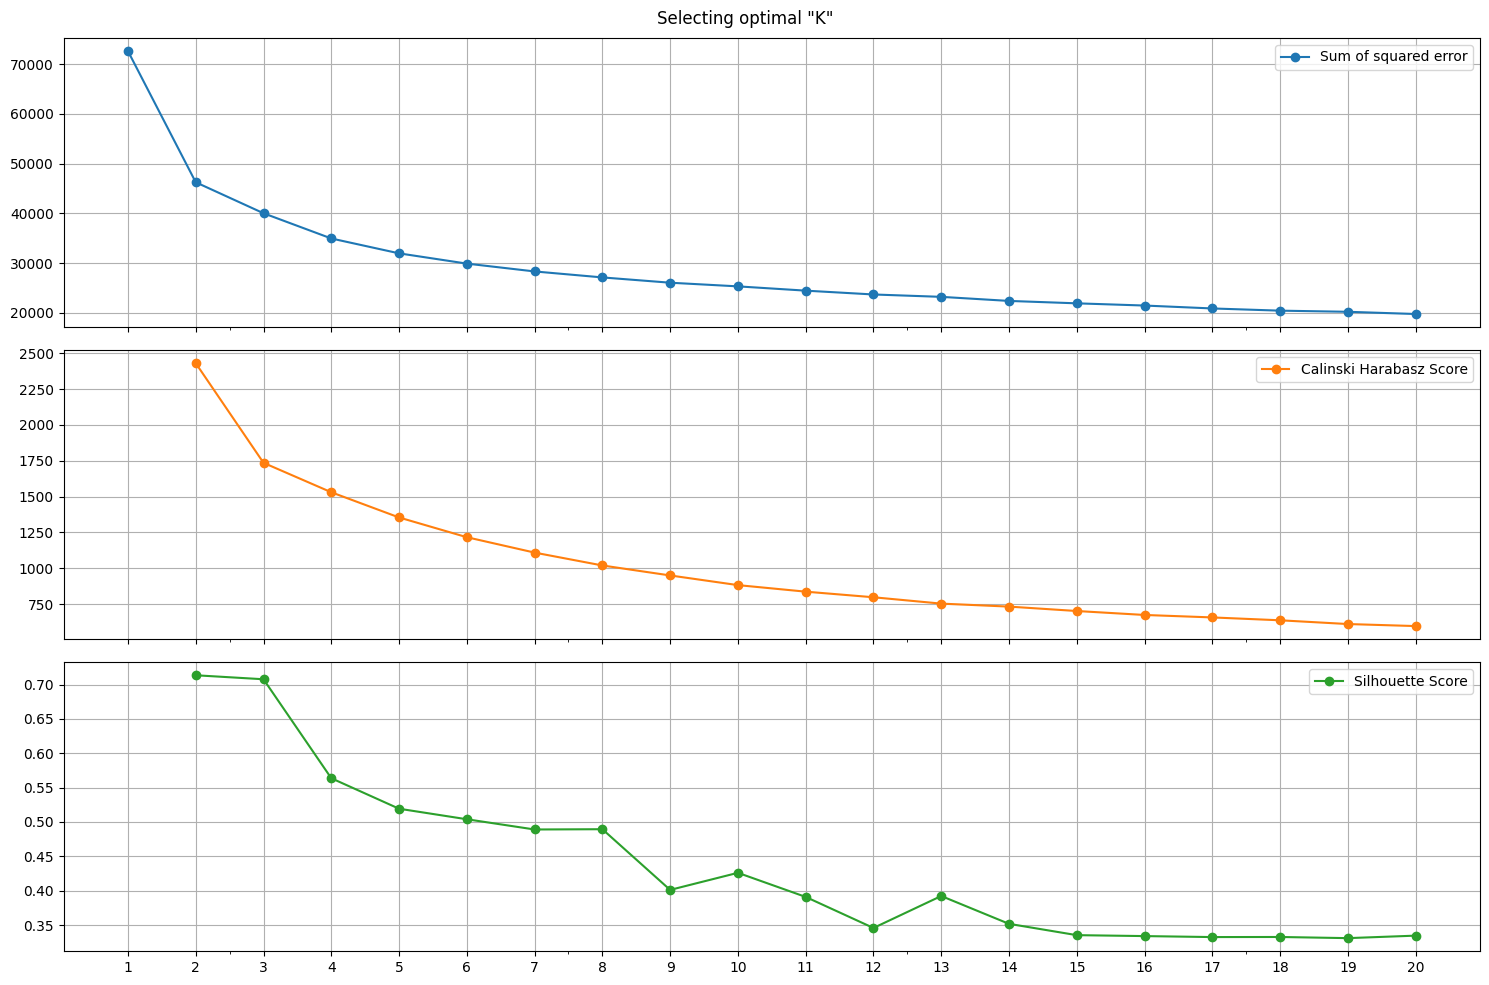

In [ ]:
# 최적의 k값 찾기

search_range = range(1, 21)
report = {}
for k in tqdm(search_range):
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=1000,
                    random_state=1,
                    verbose=0).fit(df_pivot)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia
    try:
        cluster = kmeans.predict(df_pivot)
        chs = calinski_harabasz_score(df_pivot, cluster)
        ss = silhouette_score(df_pivot, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

In [ ]:
model = KMeans(n_clusters=8, random_state=312, algorithm='auto') # algorithm: {'auto', 'full', 'elkan'}, default='auto'
model.fit(df_pivot)

KMeans(algorithm='auto', random_state=312)

In [ ]:
# 각 군집(cluster) 표시
pred = model.predict(df_pivot)

In [ ]:
# 군집별 centroids의 좌표값
centroids = model.cluster_centers_
centroids = pd.DataFrame(centroids, columns = df_pivot.columns)

centroids['cluster'] = centroids.index
centroids

gameplay    market    social  narrative  graphics  technical     value  \
0  0.160538  0.230355  0.076585   0.187721  0.111154   0.236686  0.240917   
1 -0.174207 -1.853783 -0.097109  -1.168937  0.579630  -3.974895 -0.761387   
2  6.025026  3.049882  2.605406   4.058045  4.034506   2.527695  4.110079   
3  2.574544  1.052552  7.037672   0.867992  1.549681   0.648850  2.418627   
4 -0.368393 -0.229427 -0.215724  -0.283696 -0.344874   0.000076 -0.319916   
5  1.153230  0.911942  0.374829   1.052687  1.055405   0.593441  1.166093   
6  2.725120  2.401475  0.628396   2.925703  2.819579   0.918522  2.213560   
7 -0.486444 -0.729409 -0.194421  -0.728182 -0.295993  -1.516830 -0.635656   

      audio     total  gameplay_count  market_count  social_count  \
0  0.182796 -0.020765       -0.010440      0.010903     -0.038300   
1 -0.726295  3.441396        3.370259      3.500277      2.580327   
2  2.890123  5.519779        5.779903      3.983147      2.706290   
3  0.541774  3.337414        2.612620      1.513219      6.116620   
4 -0.316367 -0.450250       -0.450565     -0.372638     -0.281344   
5  1.283303  0.860180        0.907029      0.621634      0.247043   
6  3.039760  2.022691        2.126113      2.001969      0.473721   
7 -0.606328  0.871720        0.842147      0.639017      0.678942   

   narrative_count  graphics_count  technical_count  value_count  audio_count  \
0         0.027827       -0.018862        -0.101072     0.009783     0.063744   
1         2.276758        3.108441         4.252078     2.661115     1.694185   
2         5.399579        5.051388         4.000043     4.354410     4.478325   
3         1.085031        1.915258         2.171565     2.241487     1.360435   
4        -0.411649       -0.419755        -0.337732    -0.392547    -0.441806   
5         0.905019        0.844220         0.446974     0.846393     1.233830   
6         2.627985        2.256197         0.992866     1.770474     2.911730   
7         0.609643        0.812062         1.128082     0.836027     0.480220   

   cluster  
0        0  
1        1  
2        2  
3        3  
4        4  
5        5  
6        6  
7        7

In [ ]:
df_pivot['cluster'] = pred
df_pivot.head()

gameplay    market    social  narrative  graphics  technical     value  \
0  4.475244  2.288549  6.673113   1.148476  2.606041   1.099899  2.822633   
1 -0.035124  0.584825 -0.191812  -0.259897  1.020793  -0.806460 -0.481629   
2 -0.393689 -0.080043 -0.220860  -0.247093 -0.344959   0.206581 -0.238506   
3 -0.495596 -0.204706 -0.259590  -0.375127 -0.442513   0.022392 -0.393220   
4 -0.318201  0.086174 -0.298320  -0.259897 -0.235211   0.077649 -0.249557   

      audio     total  gameplay_count  market_count  social_count  \
0  0.207267  5.188829        4.532797      4.873727      6.726767   
1  0.114336  2.706213        2.474813      2.021834      4.861932   
2 -0.422604 -0.574388       -0.588194     -0.455748     -0.370861   
3 -0.546514 -0.555063       -0.535118     -0.455748     -0.354784   
4 -0.298695 -0.527782       -0.529982     -0.241856     -0.378899   

   narrative_count  graphics_count  technical_count  value_count  audio_count  \
0         1.469313        2.512727         5.995394     2.591146     1.656379   
1        -0.016894        0.690748         1.468446     0.170561     0.352205   
2        -0.527423       -0.378400        -0.391384    -0.565211    -0.609458   
3        -0.538768       -0.555537        -0.469729    -0.586538    -0.517244   
4        -0.476370       -0.429010        -0.483354    -0.538552    -0.530417   

   cluster  
0        3  
1        7  
2        4  
3        4  
4        4

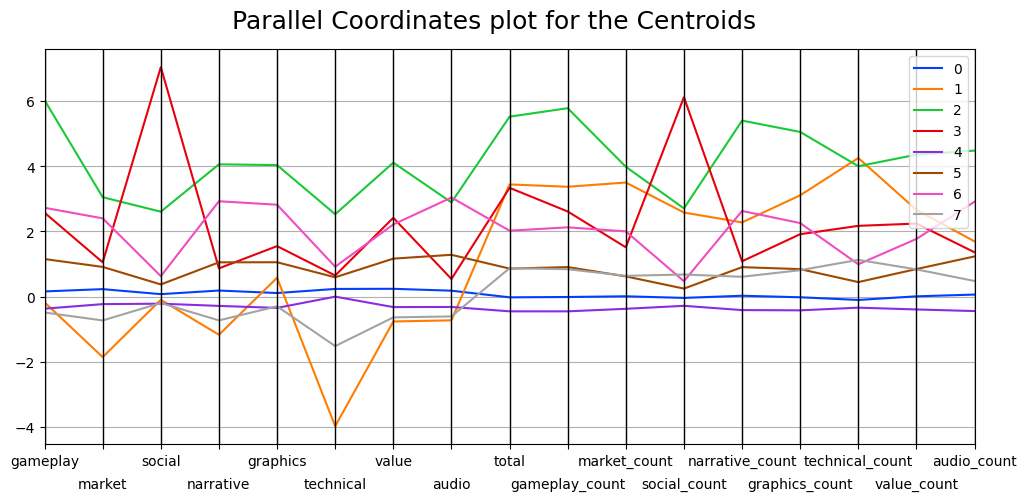

In [ ]:
# Cluster별 centroids 확인
centroids['cluster'] = centroids.index
palette = sns.color_palette("bright", 10)
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    parallel_coordinates(df, 'cluster', color=palette)

    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

display_parallel_coordinates_centroids(centroids, 5)

In [ ]:
df_pivot['k_means_cluster'] = pred
df_pivot['k_silhouette_coeff'] = silhouette_samples(df_pivot, df_pivot['k_means_cluster'])

k_average_score = silhouette_score(df_pivot, df_pivot['k_means_cluster'])
print('Average Silhouette Score:{0:.3f}'.format(k_average_score))

Average Silhouette Score:0.664


In [ ]:
# 군집별 평균 silhouette_score 값
print(df_pivot.groupby('k_means_cluster')['k_silhouette_coeff'].mean())

# silhouette_score 표준편차
print('표준편차:', df_pivot.groupby('k_means_cluster')['k_silhouette_coeff'].mean().std())

k_means_cluster
0    0.592594
1    0.138808
2    0.050996
3    0.182103
4    0.826913
5    0.156925
6    0.016759
7    0.265294
Name: k_silhouette_coeff, dtype: float64
표준편차: 0.28370961639293224


100%|██████████| 56/56 [00:02<00:00, 26.87it/s]


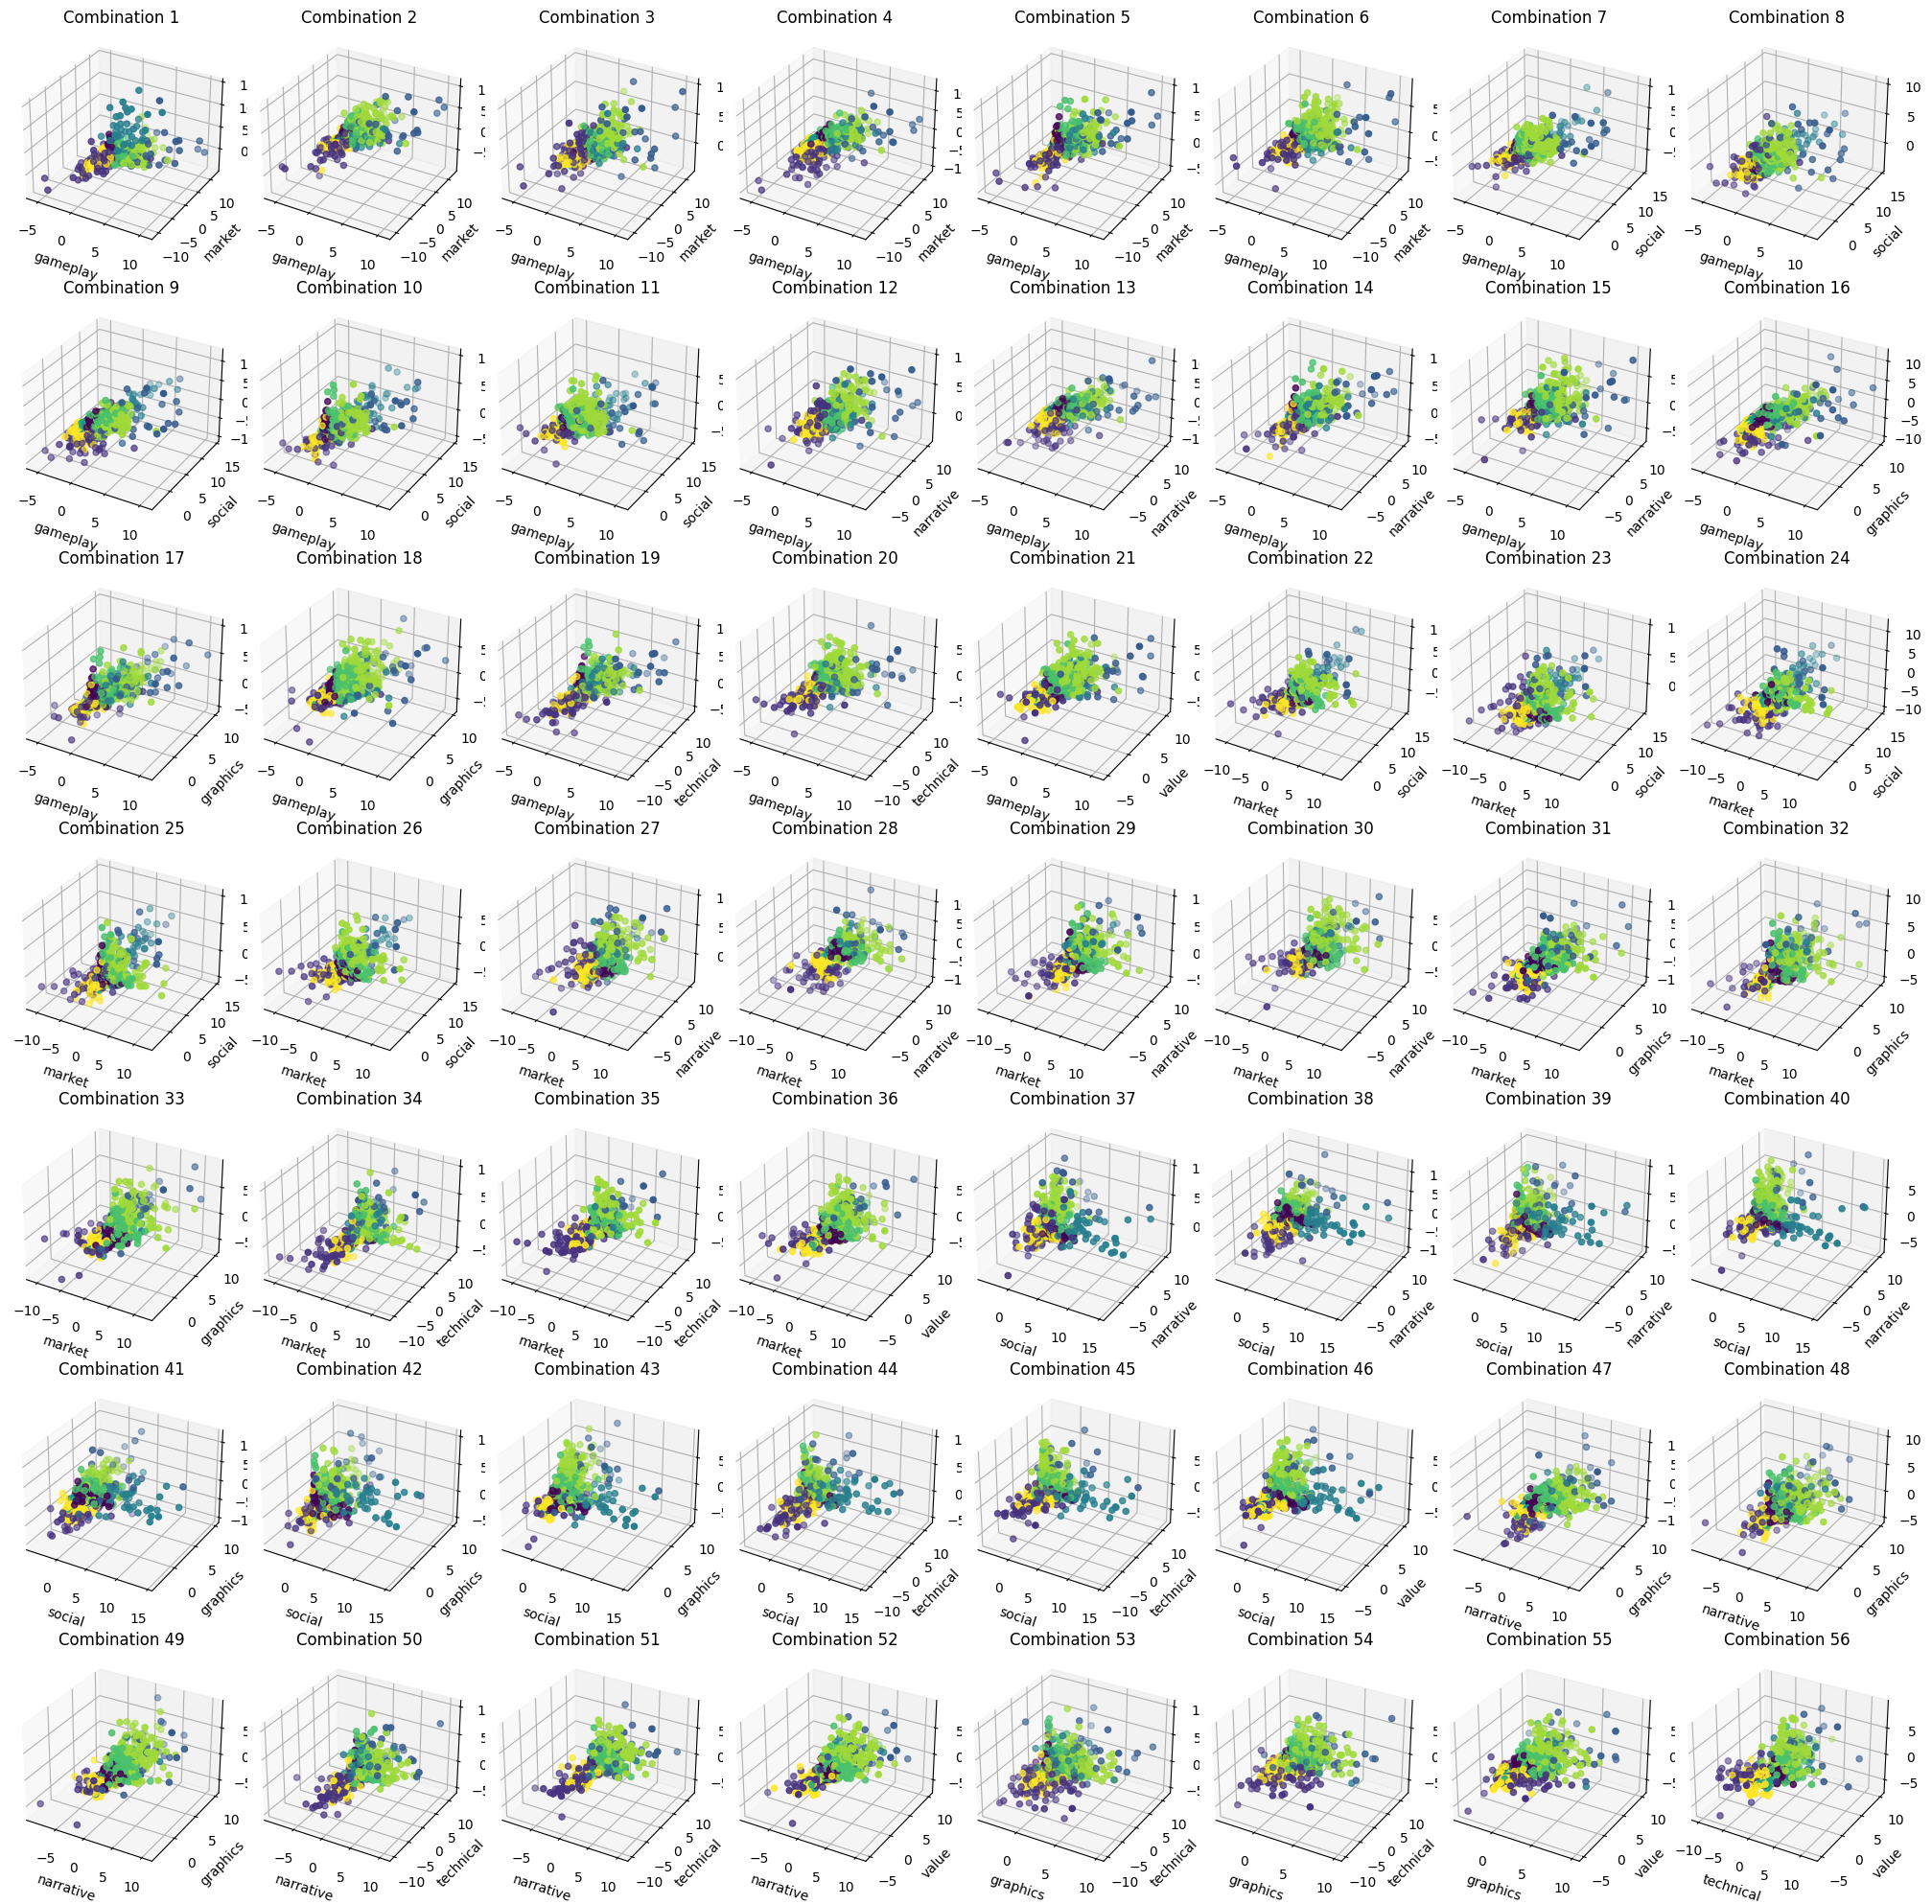

In [ ]:
#3차원 시각화

# 8개 열 중 3개를 선택하는 모든 경우
combinations = list(itertools.combinations(aspects, 3))

# 3차원 그래프로 시각화
fig = plt.figure(figsize=(20, 20))
num_plots = len(combinations)
rows = int(np.sqrt(num_plots))
cols = int(np.ceil(num_plots / rows))

for i, combination in enumerate(tqdm(combinations)):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    ax.scatter(df_pivot[combination[0]], df_pivot[combination[1]], df_pivot[combination[2]], c=df_pivot['k_means_cluster'])
    ax.set_xlabel(combination[0])
    ax.set_ylabel(combination[1])
    ax.set_zlabel(combination[2])
    ax.set_title(f"Combination {i + 1}")

plt.tight_layout()
plt.show()

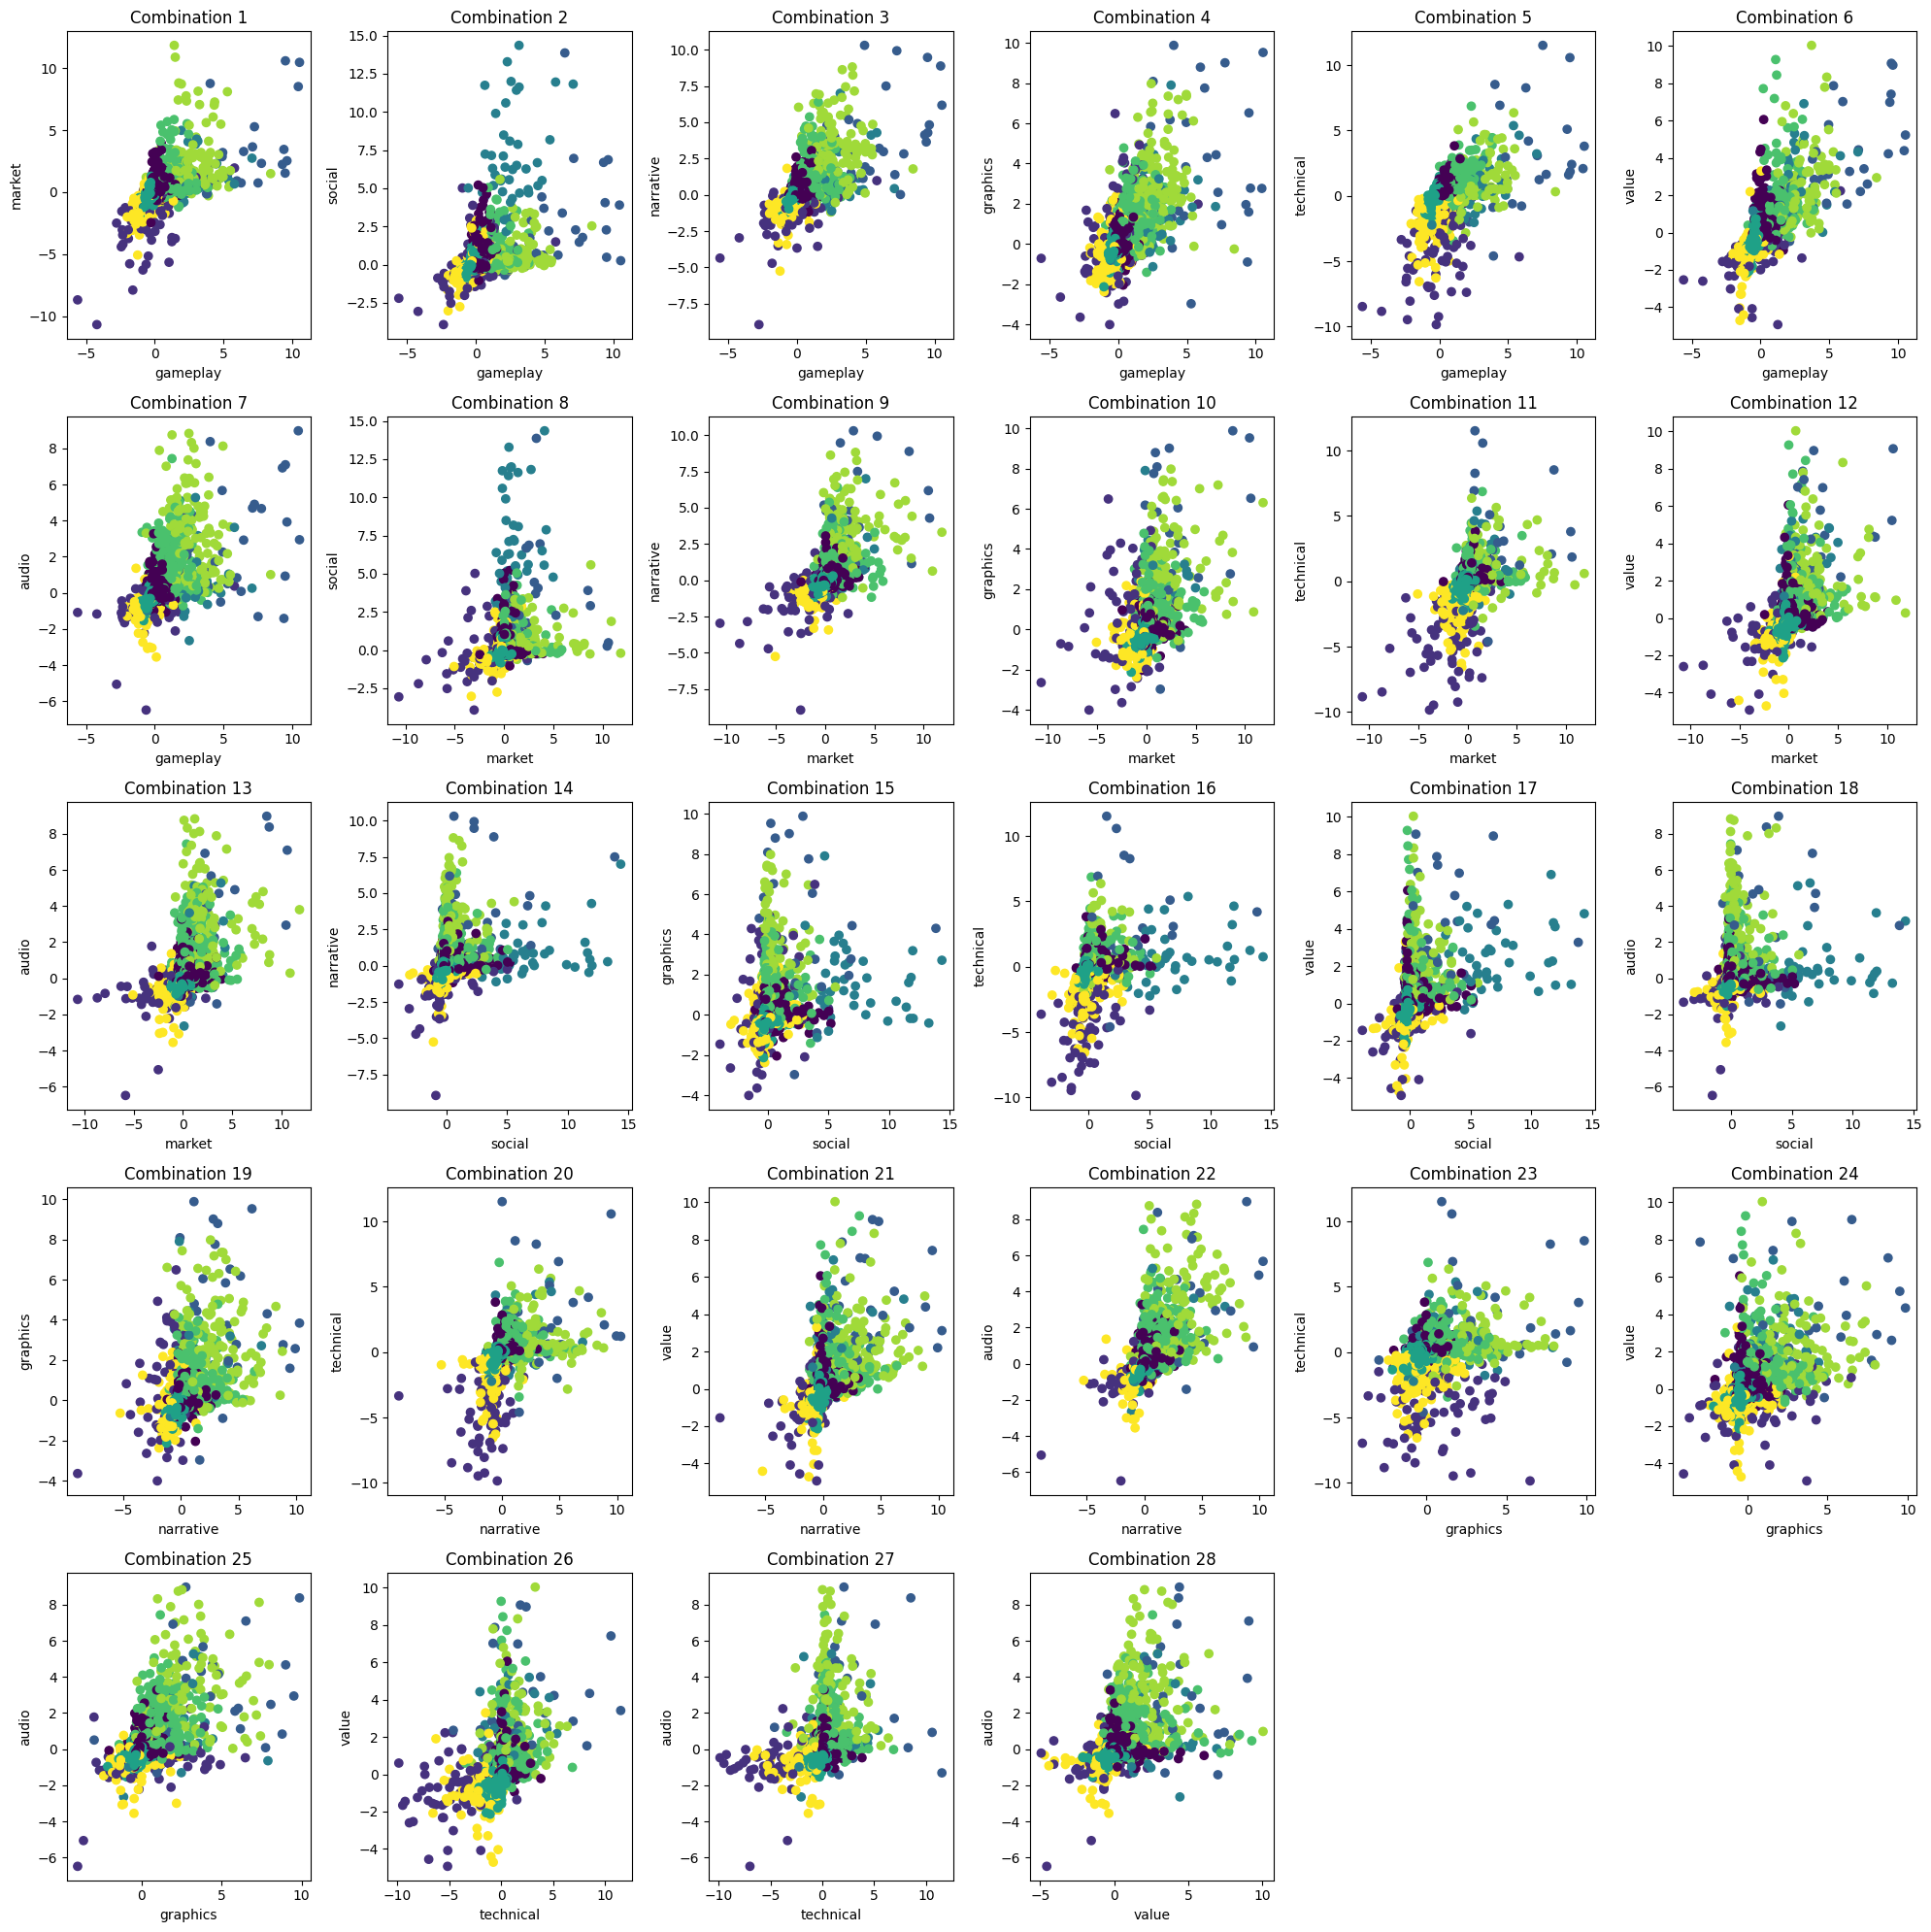

In [ ]:
# 2차원 시각화

# 8개 열 중 2개를 선택하는 모든 경우
combinations = list(itertools.combinations(aspects, 2))

# 2차원 그래프로 시각화
fig = plt.figure(figsize=(20, 20))
num_plots = len(combinations)
rows = int(np.sqrt(num_plots))
cols = int(np.ceil(num_plots / rows))

for i, combination in enumerate(combinations):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.scatter(df_pivot[combination[0]], df_pivot[combination[1]], c=df_pivot['k_means_cluster'])
    ax.set_xlabel(combination[0])
    ax.set_ylabel(combination[1])
    ax.set_title(f"Combination {i + 1}")

plt.tight_layout()
plt.show()

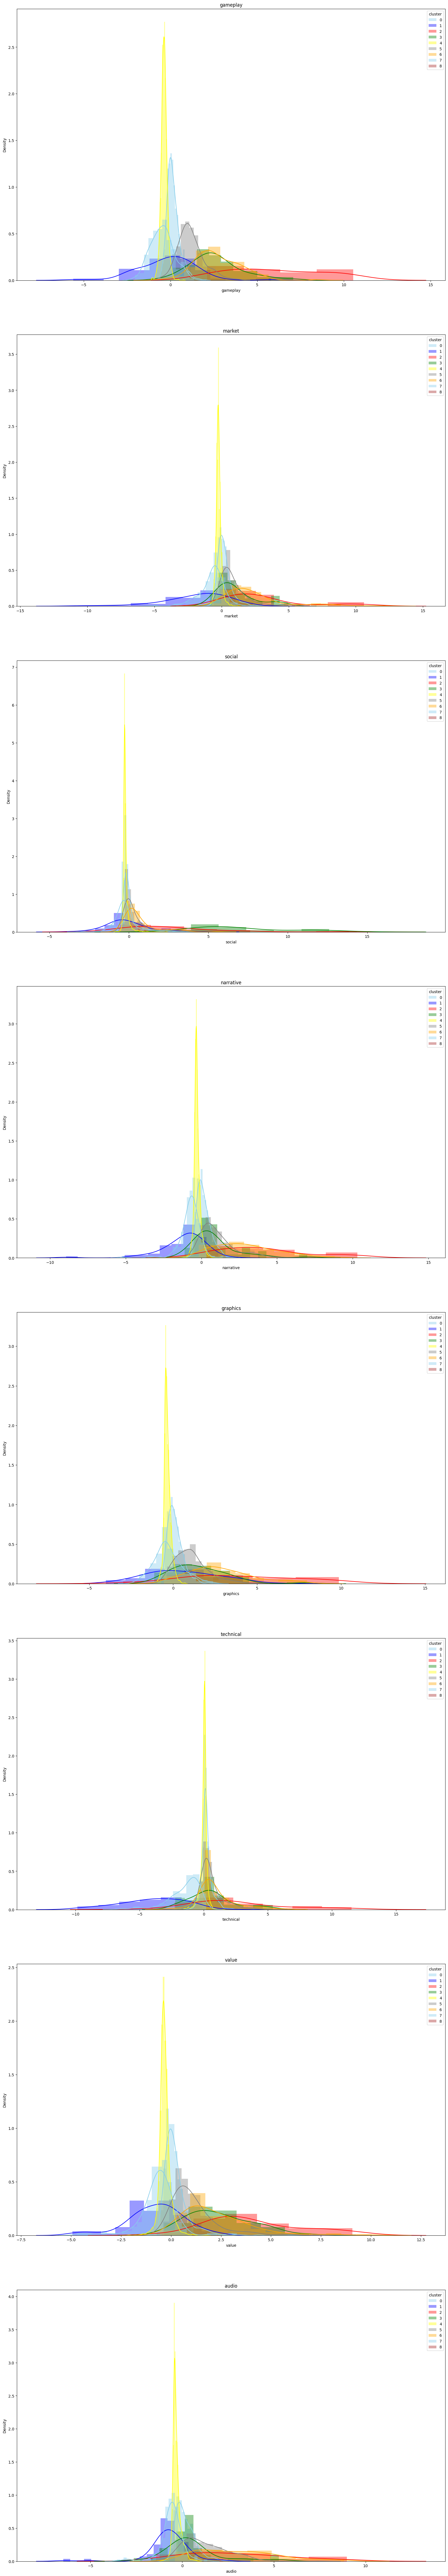

In [ ]:
# plot마다 그림 사이즈 지정
fig, axes = plt.subplots(8, 1, figsize=(20, 120))

for i, aspect in enumerate(aspects):
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 0][aspect], color="skyblue", label=0, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 1][aspect], color="blue", label=1, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 2][aspect], color="red", label=2, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 3][aspect], color="green", label=3, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 4][aspect], color="yellow", label=4, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 5][aspect], color="grey", label=5, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 6][aspect], color="orange", label=6, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 7][aspect], color="skyblue", label=7, ax=axes[i])
    sns.distplot(df_pivot[df_pivot.k_means_cluster == 8][aspect], color="brown", label=8, ax=axes[i])
    axes[i].legend(title="cluster")
    axes[i].set_title(aspect)

plt.show()

## 각 게임을 클러스터에 할당

In [ ]:
df_pivot_init = df_pivot.drop(['appid'], axis = 1)
df_pivot_init2 = scaler.transform(df_pivot_init)
df_pivot_init = pd.DataFrame(df_pivot_init2, columns=df_pivot_init.columns)

In [ ]:
pred_init = model.predict(df_pivot_init)
df_pivot_init['cluster'] = pred_init
df_pivot_init

gameplay    market    social  narrative  graphics  technical     value  \
0     7.562676  7.275059  2.073904   5.757695 -4.564157   0.943338  2.071162   
1     4.475244  2.288549  6.673113   1.148476  2.606041   1.099899  2.822633   
2    -0.035124  0.584825 -0.191812  -0.259897  1.020793  -0.806460 -0.481629   
3    -0.393689 -0.080043 -0.220860  -0.247093 -0.344959   0.206581 -0.238506   
4    -0.495596 -0.204706 -0.259590  -0.375127 -0.442513   0.022392 -0.393220   
...        ...       ...       ...        ...       ...        ...       ...   
4458 -0.420109 -0.204706  0.011522  -0.362324 -0.393736   0.151324 -0.293761   
4459 -0.593730 -0.537140 -0.288637  -0.439144 -0.735174  -0.474919 -0.625292   
4460 -0.555986 -0.370923 -0.317685  -0.387931 -0.479096  -0.198635 -0.890517   
4461 -0.371042  0.003065 -0.153082  -0.349520 -0.466901   0.105277  0.048821   
4462 -0.314427 -0.080043 -0.036891  -0.323914 -0.357153   0.040811 -0.393220   

         audio     total  gameplay_count  market_count  social_count  \
0     1.787110  6.999638        7.215711      7.547377      2.763992   
1     0.207267  5.188829        4.532797      4.873727      6.726767   
2     0.114336  2.706213        2.474813      2.021834      4.861932   
3    -0.422604 -0.574388       -0.588194     -0.455748     -0.370861   
4    -0.546514 -0.555063       -0.535118     -0.455748     -0.354784   
...        ...       ...             ...           ...           ...   
4458 -0.401953 -0.575524       -0.634422     -0.509221     -0.173928   
4459 -0.546514 -0.250420       -0.281722     -0.027964     -0.266366   
4460 -0.463908 -0.518688       -0.550527     -0.366626     -0.374880   
4461 -0.412279 -0.545969       -0.598467     -0.402275     -0.326651   
4462 -0.309021 -0.566431       -0.581346     -0.420099     -0.258327   

      narrative_count  graphics_count  technical_count  value_count  \
0            5.672671       11.306308         3.593965     2.777755   
1            1.469313        2.512727         5.995394     2.591146   
2           -0.016894        0.690748         1.468446     0.170561   
3           -0.527423       -0.378400        -0.391384    -0.565211   
4           -0.538768       -0.555537        -0.469729    -0.586538   
...               ...             ...              ...          ...   
4458        -0.578476       -0.599821        -0.408416    -0.581206   
4459        -0.294849       -0.226568        -0.251727    -0.447914   
4460        -0.516078       -0.637779        -0.333477    -0.085359   
4461        -0.601167       -0.644105        -0.479947    -0.314622   
4462        -0.550114       -0.523905        -0.476541    -0.618528   

      audio_count  cluster  
0        4.989267        2  
1        1.656379        3  
2        0.352205        7  
3       -0.609458        4  
4       -0.517244        4  
...           ...      ...  
4458    -0.642392        4  
4459    -0.214254        4  
4460    -0.616045        4  
4461    -0.668739        4  
4462    -0.576524        4  

[4463 rows x 18 columns]

In [ ]:
df_pivot_init.to_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/df_pivot_init.csv", index = False)

In [ ]:
appid_df = df_pivot['appid'].astype(int)
appid_df.reset_index(drop=True, inplace = True)
df_pivot_init.reset_index(drop=True, inplace = True)

game_with_cluster = pd.concat([appid_df, df_pivot_init], axis = 1)
game_with_cluster.reset_index(drop=True, inplace = True)
game_with_cluster

appid  gameplay    market    social  narrative  graphics  technical  \
0          70  7.562676  7.275059  2.073904   5.757695 -4.564157   0.943338   
1         440  4.475244  2.288549  6.673113   1.148476  2.606041   1.099899   
2         570 -0.035124  0.584825 -0.191812  -0.259897  1.020793  -0.806460   
3        3010 -0.393689 -0.080043 -0.220860  -0.247093 -0.344959   0.206581   
4        3130 -0.495596 -0.204706 -0.259590  -0.375127 -0.442513   0.022392   
...       ...       ...       ...       ...        ...       ...        ...   
4458  2242760 -0.420109 -0.204706  0.011522  -0.362324 -0.393736   0.151324   
4459  2262770 -0.593730 -0.537140 -0.288637  -0.439144 -0.735174  -0.474919   
4460  2277860 -0.555986 -0.370923 -0.317685  -0.387931 -0.479096  -0.198635   
4461  2291670 -0.371042  0.003065 -0.153082  -0.349520 -0.466901   0.105277   
4462  2306590 -0.314427 -0.080043 -0.036891  -0.323914 -0.357153   0.040811   

         value     audio     total  gameplay_count  market_count  \
0     2.071162  1.787110  6.999638        7.215711      7.547377   
1     2.822633  0.207267  5.188829        4.532797      4.873727   
2    -0.481629  0.114336  2.706213        2.474813      2.021834   
3    -0.238506 -0.422604 -0.574388       -0.588194     -0.455748   
4    -0.393220 -0.546514 -0.555063       -0.535118     -0.455748   
...        ...       ...       ...             ...           ...   
4458 -0.293761 -0.401953 -0.575524       -0.634422     -0.509221   
4459 -0.625292 -0.546514 -0.250420       -0.281722     -0.027964   
4460 -0.890517 -0.463908 -0.518688       -0.550527     -0.366626   
4461  0.048821 -0.412279 -0.545969       -0.598467     -0.402275   
4462 -0.393220 -0.309021 -0.566431       -0.581346     -0.420099   

      social_count  narrative_count  graphics_count  technical_count  \
0         2.763992         5.672671       11.306308         3.593965   
1         6.726767         1.469313        2.512727         5.995394   
2         4.861932        -0.016894        0.690748         1.468446   
3        -0.370861        -0.527423       -0.378400        -0.391384   
4        -0.354784        -0.538768       -0.555537        -0.469729   
...            ...              ...             ...              ...   
4458     -0.173928        -0.578476       -0.599821        -0.408416   
4459     -0.266366        -0.294849       -0.226568        -0.251727   
4460     -0.374880        -0.516078       -0.637779        -0.333477   
4461     -0.326651        -0.601167       -0.644105        -0.479947   
4462     -0.258327        -0.550114       -0.523905        -0.476541   

      value_count  audio_count  cluster  
0        2.777755     4.989267        2  
1        2.591146     1.656379        3  
2        0.170561     0.352205        7  
3       -0.565211    -0.609458        4  
4       -0.586538    -0.517244        4  
...           ...          ...      ...  
4458    -0.581206    -0.642392        4  
4459    -0.447914    -0.214254        4  
4460    -0.085359    -0.616045        4  
4461    -0.314622    -0.668739        4  
4462    -0.618528    -0.576524        4  

[4463 rows x 19 columns]

In [ ]:
game_with_cluster.to_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/game_with_cluster.csv", index = False)

In [ ]:
df_with_cluster = df.merge(game_with_cluster[['appid', 'cluster']], on='appid', how='left')
df_with_cluster

recommendationid language  \
0                77745072  english   
1                82366432  english   
2                78181685  english   
3                77736636  english   
4               122502322  english   
...                   ...      ...   
4843593          77884964  english   
4843594          77884887  english   
4843595          77881237  english   
4843596          77879355  english   
4843597          77879254  english   

                                                    review timestamp_created  \
0        A turn based roguelite that feels like: +Dunge...        2020-10-18   
1        [b] If you are looking for a longterm Roguelik...        2020-12-14   
2        I just want to point out that the rarest achie...        2020-10-26   
3        It's an okay rogue-lite and thus an okay optio...        2020-10-18   
4        Honestly, I got the game through a bundle. It ...        2022-09-19   
...                                                    ...               ...   
4843593                           Frictional did it again!        2020-10-20   
4843594  Frictional Games are masters of their craft. I...        2020-10-20   
4843595  Thrilling. I'm just an hour in, and I like to ...        2020-10-20   
4843596  On my first 60 minutes of playthrough, I must ...        2020-10-20   
4843597  Update:I'm turning this to a positive review a...        2020-10-20   

        timestamp_updated  voted_up  votes_up  votes_funny  \
0              2020-10-18      True       145            0   
1              2020-12-14      True        69            2   
2              2020-10-26      True        44           13   
3              2020-11-13     False       112            4   
4              2022-09-19     False        68            6   
...                   ...       ...       ...          ...   
4843593        2020-10-20      True         0            0   
4843594        2020-10-20      True         0            0   
4843595        2020-10-20      True         0            0   
4843596        2020-10-20      True         0            0   
4843597        2020-10-26      True         0            0   

         weighted_vote_score  comment_count  steam_purchase  \
0                   0.871512              0            True   
1                   0.800069              0            True   
2                   0.761518              0            True   
3                   0.749369              0            True   
4                   0.747804              0           False   
...                      ...            ...             ...   
4843593             0.000000              0            True   
4843594             0.000000              0            True   
4843595             0.000000              0            True   
4843596             0.000000              0            True   
4843597             0.000000              0            True   

         received_for_free  written_during_early_access  \
0                    False                        False   
1                    False                        False   
2                    False                        False   
3                    False                        False   
4                    False                        False   
...                    ...                          ...   
4843593              False                        False   
4843594              False                        False   
4843595              False                        False   
4843596              False                        False   
4843597              False                        False   

         hidden_in_steam_china  steam_china_location  author_steamid  \
0                        False                   NaN    7.656120e+16   
1                        False                   NaN    7.656120e+16   
2                        False                   NaN    7.656120e+16   
3                        False                   NaN    7.656120e+16   
4                   

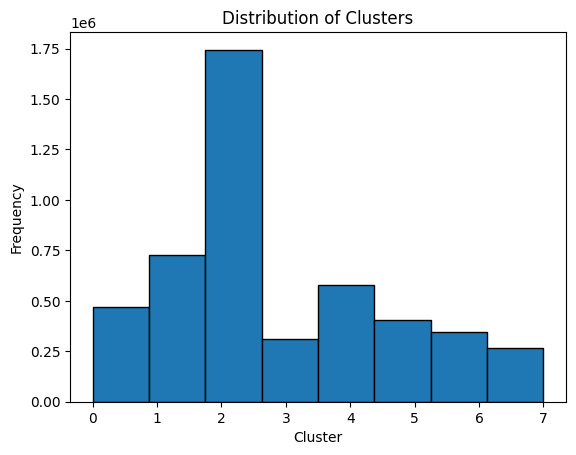

In [ ]:
# Cluster 개수 분포 히스토그램
plt.hist(df_with_cluster['cluster'], bins = 8, edgecolor = 'black')

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Distribution of Clusters')

plt.show()

In [ ]:
df_with_cluster.to_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/df_with_cluster.csv", index = False)

# review chain 생성

- 게임 시작 기준
- 최근 플레이 시점 & 댓글 시점 비율 고려

In [ ]:
merged_df = pd.read_csv("/content/drive/MyDrive/DA-STEAM 게임시장분석/data/merged_df_noreview.csv")
grouped_df = merged_df.groupby(['author_steamid'])
del merged_df

user_review_chain = {}

for name, group in tqdm(grouped_df):
      cluster_history = []
      appid_history = []
      voted_history = []
      player_history = []
      playtime_history = []
      review_category = []
      score_history = []
      for idx, row in group.iterrows():
          cluster_history.append(row['cluster'])
          appid_history.append(row['appid'])
          voted_history.append(row['voted_up'])
          player_history.append([row['author_num_games_owned'],row['author_num_reviews']])
          playtime_history.append([row['author_playtime_forever'],row['author_playtime_at_review']])
          review_category.append(row['review_category'])
          score_history.append([row['gameplay_label'],row['market_label'],row['social_label'],row['narrative_label'],row['graphics_label'],row['technical_label'],row['value_label'],row['audio_label']])

      user_review_chain[name] = [cluster_history,appid_history,voted_history, player_history, playtime_history, review_category, score_history]

100%|██████████| 2521105/2521105 [14:34<00:00, 2881.49it/s]


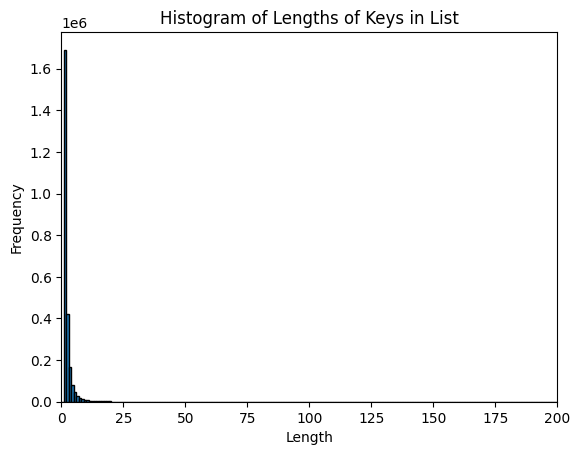

In [ ]:
# 예시로 사용할 key가 있는 리스트 데이터
keys = list(user_review_chain.values())

# 리스트의 길이를 저장할 리스트 생성
lengths = [len(key[0]) for key in keys]

# 히스토그램 그래프 그리기
plt.hist(lengths, bins=range(0, max(lengths)+1), edgecolor='black')

# 그래프 제목과 축 제목 설정
plt.title('Histogram of Lengths of Keys in List')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xlim(0,200)

# 그래프 출력
plt.show()

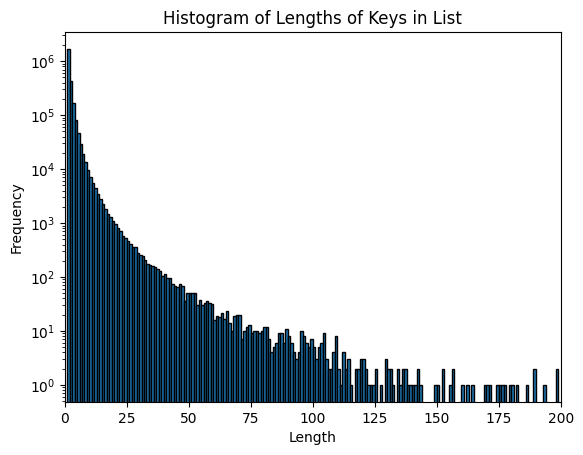

In [ ]:
## log scale

# 리스트의 길이를 저장할 리스트 생성
lengths = [len(key[0]) for key in keys]

# 히스토그램 그래프 그리기
plt.hist(lengths, bins=range(0, max(lengths)+1), edgecolor='black')

# y축을 로그 스케일로 변경합니다.
plt.yscale('log')

# 그래프 제목과 축 제목 설정
plt.title('Histogram of Lengths of Keys in List')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.xlim(0,200)

# 그래프 출력
plt.show()

In [ ]:
# Counter 객체를 사용하여 리스트의 원소 개수 세기
counter = Counter(lengths)

# 결과 출력
print(counter)

Counter({1: 1691406, 2: 421747, 3: 167168, 4: 82449, 5: 46746, 6: 29155, 7: 19248, 8: 13330, 9: 9783, 10: 7188, 11: 5432, 12: 4378, 13: 3401, 14: 2802, 15: 2232, 16: 1827, 17: 1472, 18: 1308, 19: 1107, 20: 962, 21: 828, 22: 723, 23: 584, 24: 526, 25: 457, 26: 410, 27: 360, 28: 354, 29: 279, 30: 261, 31: 250, 32: 205, 33: 173, 34: 166, 35: 158, 36: 153, 37: 142, 38: 129, 40: 115, 39: 104, 42: 95, 41: 94, 46: 74, 43: 73, 47: 69, 44: 69, 45: 65, 52: 51, 51: 51, 50: 51, 49: 50, 54: 38, 57: 36, 48: 36, 58: 33, 56: 33, 59: 31, 55: 30, 53: 30, 65: 23, 63: 22, 70: 20, 69: 20, 61: 19, 68: 19, 62: 18, 64: 17, 60: 16, 66: 14, 74: 13, 80: 12, 81: 12, 73: 12, 89: 11, 79: 10, 72: 10, 76: 10, 95: 10, 77: 10, 67: 10, 104: 9, 86: 9, 75: 9, 87: 9, 78: 9, 96: 8, 90: 8, 109: 8, 82: 7, 71: 7, 99: 7, 85: 6, 97: 6, 88: 6, 91: 6, 103: 6, 102: 5, 84: 5, 98: 5, 100: 5, 94: 4, 108: 4, 83: 4, 112: 4, 92: 4, 101: 3, 93: 3, 129: 3, 114: 3, 120: 3, 105: 3, 119: 3, 130: 2, 125: 2, 208: 2, 142: 2, 121: 2, 156: 2, 113:

In [ ]:
# JSON 파일로 저장
with open('/content/drive/MyDrive/DA-STEAM 게임시장분석/data/user_review_chain.json', 'w') as file:
    json.dump(user_review_chain, file)